# Spectral unmixing of fluorescent dyes

Adapted from *Marina Alterman, Yoav Schechner, and Aryeh Weiss, “Multiplexed Fluorescence Unmixing” (2010): 1–8.*


A mixture of $n_{dyes}$ dyes is excited with $S$ different laser line configurations, and the emitted flourescence is measured at $F$ diffrent wavelength bands. For a particular exitation source $s$ and filter band $f$ the corresponding intensity of the image $i_{f,s}$ is given by

$$i_{f,s} = \frac{q_{elect}^{cam}(f)}{g_{gray}^{cam}} \sum_{d=0}^{n_{dyes}} \mathcal{P}\left( N_{d} \left( f,s \right) \right) + \frac{1}{g_{gray}^{cam}} \mathcal{N}\left( 0,\sigma^2_{elect} \right)$$

where

$i_{f,s} \; \left[ \textrm{graylevel} \right]$ gray-scale value of signal in emission filter band $f$ with excitation source $s$.

$g_{gray}^{cam} \; \left[ \textrm{elect} \cdot \textrm{graylevel}^{-1} \right]$ conversion factor from photoelectrons to camera gray-scale values.

$q_{elect}^{cam}(f) \; \left[ \textrm{elect} \cdot \textrm{photon}^{-1} \right]$ quantum efficiency of the detector in filter band $f$.

$n_{dyes} \; \left[ \textrm{int} \right]$ number of dyes.

$N_{d} \left( f,s \right) \; \left[ \textrm{photons} \right]$ expected number of photons from dye $d$ in filter band $f$ with exication source $s$. $N_{0} \left( f,s \right)$ is the expected number of background photons.

$\sigma_{elect} \; \left[ \textrm{electron} \right]$ is the standard deviation of the sensor noise.

$\mathcal{P} \left( \lambda \right)$ is a poisson distribution with rate $\lambda$.

$\mathcal{N} \left( \mu, \sigma^2 \right)$ is a normal distribution with mean $\mu$ and variance $\sigma^2$.



The expected number of photons from dye $d$ in filter band $f$ with exication source $s$ can be determined from the total collected number of photons for that dye by

$$N_{d} \left( f,s \right) = \alpha_{d}(s) \epsilon_{d}(f) N_d^{Tot}$$

where

$N_d^{Tot}$ is the total number of photons collected from dye $d$.

$\alpha_{d}(s)$ is the normalised absorption of dye $d$ of source $s$. This factor can take into account different exciation powers for different sources $s$.

$\epsilon_{d}(f)$ is the normalised emission of dye $d$ in band $f$. This factor can take into account different transmission coefficicents for different bands $f$.

$ 0 \leq \alpha_{d}(s), \; 0 \leq \epsilon_{d}(f) \; \forall \; s, d$ and $\sum_{f,s}\alpha_{d}(s) \epsilon_{d}(f) = 1$.






## setup

In [1]:
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

## simulation

In [3]:
from unmixer import generate, infer, compare

In [15]:
from scipy.stats import norm
from numpy import linspace, asarray
x_wv = linspace(400,700,32)
centers = [425, 505, 561, 600]
y_em = asarray([norm.pdf(x_wv, c, 20) for c in centers])

x = linspace(400,700,5)
centers = [405, 488, 541, 565]
y_ex = asarray([norm.pdf(x, c, 60) for c in centers])

In [51]:
# create coefficients and configuration
# could optionally load from JSON files (see test/resources for examples)

coeff = {'emission': y_em,
         'excitation': y_ex,
         'noise': 0.5,
         'graylevel' : 50,
         'qe' : 0.85
        }
counts = [0, 0, 1000, 1000]

signal = generate(counts, coeff)
estimate = infer(signal, coeff)
accuracy = compare(estimate, counts)

print(accuracy/asarray(counts).sum())

0.234671783117


In [52]:
estimate

array([  3.89767699e+01,   2.76410015e-01,   6.63952436e+02,
         6.74675311e+02])

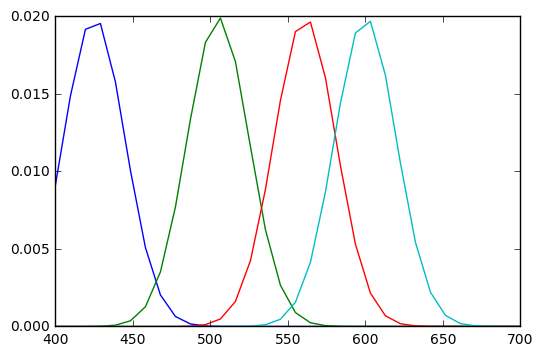

In [53]:
plt.plot(x_wv, y_em.T);

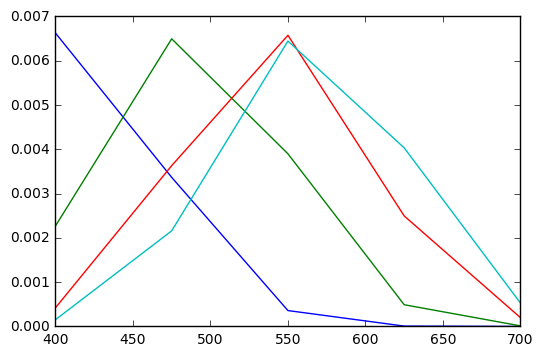

In [40]:
plt.plot(x, y_ex.T);

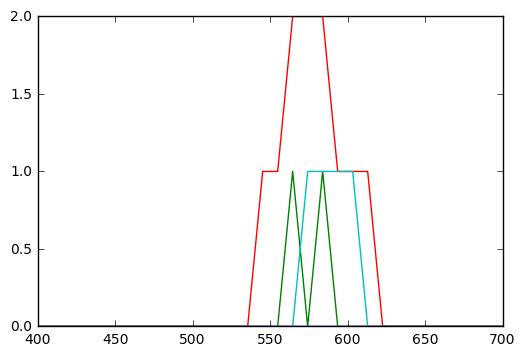

In [35]:
plt.plot(x_wv, signal);

In [36]:
signal

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 2, 0, 0],
       [0, 0, 2, 1, 0],
       [0, 1, 2, 1, 0],
       [0, 0, 1, 1, 0],
       [0, 0, 1, 1, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])